In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer

## Attendance/ Occupancy Prediction:

### Preparation

In [ ]:
# Load data
df = pd.read_csv("Master_Short_Data.csv")
df['game_date'] = pd.to_datetime(df['game_date'])

# Drop rows with missing attendance or capacity (essential)
df = df.dropna(subset=['attendance', 'arena_capacity', 'occupancy_rate'])

# Optional: Filter reasonable years if needed
df = df[(df['game_date'].dt.year >= 1996) & (df['game_date'].dt.year <= 2020)]

# # Remove outliers from 'attendance' using the IQR method 
# Q1 = df['attendance'].quantile(0.25)
# Q3 = df['attendance'].quantile(0.75)
# IQR = Q3 - Q1

# # Define bounds
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# # Filter out outliers
# df = df[(df['attendance'] >= lower_bound) & (df['attendance'] <= upper_bound)]

# Define target and features
target = 'attendance'
# target = 'occupancy_rate' 


categorical_features = [
    'team_abbreviation_home', 'team_abbreviation_away', 
    'season_type', 'rival_game', 'home_mvp', 'away_mvp', 'defending_champ_home', 'defending_champ_away'
]
numeric_features = [
    'arena_capacity', 'home_wins', 'home_losses', 'home_win_streak', 'away_win_streak',
    'away_wins', 'attendance_prev_season_avg', 'attendance_lag1', 'attendance_lag2',
    'game_year', 'game_month', 'game_dayofweek',
]

# One-Hot Encoding
df_encoded = pd.get_dummies(df[categorical_features], drop_first=True)

# Combine all features
X = pd.concat([df[numeric_features], df_encoded], axis=1)
y = df[target]

df = df.sort_values("game_date")
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

# Impute missing values in X_train and X_test
imputer = SimpleImputer(strategy='mean')
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns, index=X_test.index)


### Baseline / Linear Regression: -> MAE: 1171, RMSE: 1612, R²: 0.494

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import numpy as np

# Linear Regression model
model = LinearRegression()

# Cross-validation
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = cross_val_score(model, X_train_imputed, y_train, scoring='r2', cv=tscv)
print(f'Linear Regression Cross-Validation R² Scores: {cv_scores}')
print(f'Mean CV R²: {np.mean(cv_scores):.3f}')

# Fit the model
model.fit(X_train_imputed, y_train)

# Predict and evaluate
y_pred = model.predict(X_test_imputed)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f'MAE: {mae:.0f}, RMSE: {rmse:.0f}, R²: {r2:.3f}')

Linear Regression Cross-Validation R² Scores: [0.39445179 0.2556353  0.27297106 0.51670419 0.55126647]
Mean CV R²: 0.398
MAE: 1035, RMSE: 1457, R²: 0.580


### XGBR Regressor

In [35]:
from xgboost import XGBRegressor

model = XGBRegressor(n_estimators=100, random_state=42, verbosity=0)

# Cross-validation (optional but recommended)
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = cross_val_score(model, X_train, y_train, scoring='r2', cv=tscv)
print(f'Cross-Validation R² Scores: {cv_scores}')
print(f'Mean CV R²: {np.mean(cv_scores):.3f}')


# Fit the model
model.fit(X_train, y_train)

# Predictions on the test set - The last 0.2 percent of the dataset - chronological order kept
y_pred = model.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae:.0f}, RMSE: {rmse:.0f}, R²: {r2:.3f}')

Cross-Validation R² Scores: [ 0.51481337  0.19470355 -0.85795101  0.5743698   0.53987697]
Mean CV R²: 0.193
MAE: 847, RMSE: 1328, R²: 0.651


### Random Forest

In [36]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Use the same train/test split and features as above
# X_train_imputed, X_test_imputed, y_train, y_test are already defined

# Initialize Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# Fit the model
rf_model.fit(X_train_imputed, y_train)

# Predict on test set
y_pred_rf = rf_model.predict(X_test_imputed)

# Evaluate
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f'Random Forest MAE: {mae_rf:.0f}, RMSE: {rmse_rf:.0f}, R²: {r2_rf:.3f}')

Random Forest MAE: 792, RMSE: 1323, R²: 0.653


### Ridge and Lasso Regression

In [37]:
from sklearn.linear_model import Ridge, Lasso

# Ridge Regression
ridge_model = Ridge()
ridge_model.fit(X_train_imputed, y_train)
y_pred_ridge = ridge_model.predict(X_test_imputed)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)
print(f'Ridge MAE: {mae_ridge:.0f}, RMSE: {rmse_ridge:.0f}, R²: {r2_ridge:.3f}')

# Lasso Regression
lasso_model = Lasso()
lasso_model.fit(X_train_imputed, y_train)
y_pred_lasso = lasso_model.predict(X_test_imputed)
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
r2_lasso = r2_score(y_test, y_pred_lasso)
print(f'Lasso MAE: {mae_lasso:.0f}, RMSE: {rmse_lasso:.0f}, R²: {r2_lasso:.3f}')

Ridge MAE: 1035, RMSE: 1457, R²: 0.580
Lasso MAE: 1028, RMSE: 1451, R²: 0.583


### SVR

In [38]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

# SVR expects scaled features

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Initialize SVR model (RBF kernel is default)
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.2)

# Fit SVR
svr_model.fit(X_train_scaled, y_train)

# Predict
y_pred_svr = svr_model.predict(X_test_scaled)

# Evaluate
mae_svr = mean_absolute_error(y_test, y_pred_svr)
rmse_svr = np.sqrt(mean_squared_error(y_test, y_pred_svr))
r2_svr = r2_score(y_test, y_pred_svr)

print(f'SVR MAE: {mae_svr:.0f}, RMSE: {rmse_svr:.0f}, R²: {r2_svr:.3f}')

SVR MAE: 1629, RMSE: 2170, R²: 0.067


### K Neighbors Regressor

In [39]:
from sklearn.neighbors import KNeighborsRegressor

# Initialize KNN regressor
knn_model = KNeighborsRegressor(n_neighbors=5, n_jobs=-1)

# Fit the model
knn_model.fit(X_train_imputed, y_train)

# Predict on test set
y_pred_knn = knn_model.predict(X_test_imputed)

# Evaluate
mae_knn = mean_absolute_error(y_test, y_pred_knn)
rmse_knn = np.sqrt(mean_squared_error(y_test, y_pred_knn))
r2_knn = r2_score(y_test, y_pred_knn)

print(f'KNN MAE: {mae_knn:.0f}, RMSE: {rmse_knn:.0f}, R²: {r2_knn:.3f}')

KNN MAE: 1089, RMSE: 1831, R²: 0.336


### LGBM Regressor

In [40]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Initialize LightGBM regressor
lgbm_model = LGBMRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# Fit the model
lgbm_model.fit(X_train_imputed, y_train)

# Predict on test set
y_pred_lgbm = lgbm_model.predict(X_test_imputed)

# Evaluate
mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm)
rmse_lgbm = np.sqrt(mean_squared_error(y_test, y_pred_lgbm))
r2_lgbm = r2_score(y_test, y_pred_lgbm)

print(f'LightGBM MAE: {mae_lgbm:.0f}, RMSE: {rmse_lgbm:.0f}, R²: {r2_lgbm:.3f}')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1282
[LightGBM] [Info] Number of data points in the train set: 21200, number of used features: 92
[LightGBM] [Info] Start training from score 17254.643915
LightGBM MAE: 798, RMSE: 1261, R²: 0.685


### Cat Boost Regressor

In [41]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# CatBoost works well with categorical features, but here we use imputed numeric features
catboost_model = CatBoostRegressor(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    random_seed=42,
    verbose=100
)

catboost_model.fit(X_train_imputed, y_train)

# Predict on test set
y_pred_catboost = catboost_model.predict(X_test_imputed)

# Evaluate
mae_catboost = mean_absolute_error(y_test, y_pred_catboost)
rmse_catboost = np.sqrt(mean_squared_error(y_test, y_pred_catboost))
r2_catboost = r2_score(y_test, y_pred_catboost)

print(f'CatBoost MAE: {mae_catboost:.0f}, RMSE: {rmse_catboost:.0f}, R²: {r2_catboost:.3f}')

0:	learn: 3410.3513260	total: 16.5ms	remaining: 8.22s
100:	learn: 2143.5789642	total: 586ms	remaining: 2.31s
200:	learn: 1980.3834325	total: 1.22s	remaining: 1.81s
300:	learn: 1860.3199599	total: 1.75s	remaining: 1.16s
400:	learn: 1775.8619823	total: 2.27s	remaining: 560ms
499:	learn: 1705.1561662	total: 2.79s	remaining: 0us
CatBoost MAE: 817, RMSE: 1267, R²: 0.682


### MLP - Deep Learning

In [42]:
from sklearn.neural_network import MLPRegressor

# Initialize MLPRegressor
mlp_model = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', random_state=42, max_iter=500)

# Fit the model
mlp_model.fit(X_train_scaled, y_train)

# Predict on test set
y_pred_mlp = mlp_model.predict(scaler.transform(X_test_imputed))

# Evaluate
mae_mlp = mean_absolute_error(y_test, y_pred_mlp)
rmse_mlp = np.sqrt(mean_squared_error(y_test, y_pred_mlp))
r2_mlp = r2_score(y_test, y_pred_mlp)

print(f'MLPRegressor MAE: {mae_mlp:.0f}, RMSE: {rmse_mlp:.0f}, R²: {r2_mlp:.3f}')

MLPRegressor MAE: 1311, RMSE: 1776, R²: 0.375


c:\Users\Martin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [43]:
results = pd.DataFrame({
    'Model': [
        'Linear Regression',
        'Random Forest',
        'Ridge Regression',
        'Lasso Regression',
        'SVR',
        'MLPRegressor',
        'XGBoost',
        'LightGBM',
        'CatBoost',
        'KNN'
    ],
    'MAE': [
        mae,
        mae_rf,
        mae_ridge,
        mae_lasso,
        mae_svr,
        mae_mlp,
        mae,
        mae_lgbm,
        mae_catboost,
        mae_knn
    ],
    'RMSE': [
        rmse,
        rmse_rf,
        rmse_ridge,
        rmse_lasso,
        rmse_svr,
        rmse_mlp,
        rmse,
        rmse_lgbm,
        rmse_catboost,
        rmse_knn
    ],
    'R²': [
        r2,
        r2_rf,
        r2_ridge,
        r2_lasso,
        r2_svr,
        r2_mlp,
        r2,
        r2_lgbm,
        r2_catboost,
        r2_knn
    ]
})

print(results)

               Model          MAE         RMSE        R²
0  Linear Regression   846.858451  1327.530949  0.650977
1      Random Forest   792.082641  1322.886025  0.653415
2   Ridge Regression  1035.009493  1456.644638  0.579785
3   Lasso Regression  1027.647453  1451.477699  0.582761
4                SVR  1628.905055  2170.232444  0.067225
5       MLPRegressor  1310.927605  1776.350407  0.375084
6            XGBoost   846.858451  1327.530949  0.650977
7           LightGBM   797.792365  1261.288190  0.684940
8           CatBoost   817.174878  1266.643647  0.682259
9                KNN  1088.845614  1831.166519  0.335920


### Feature Importance Anaylsis

#### Build in Analysis

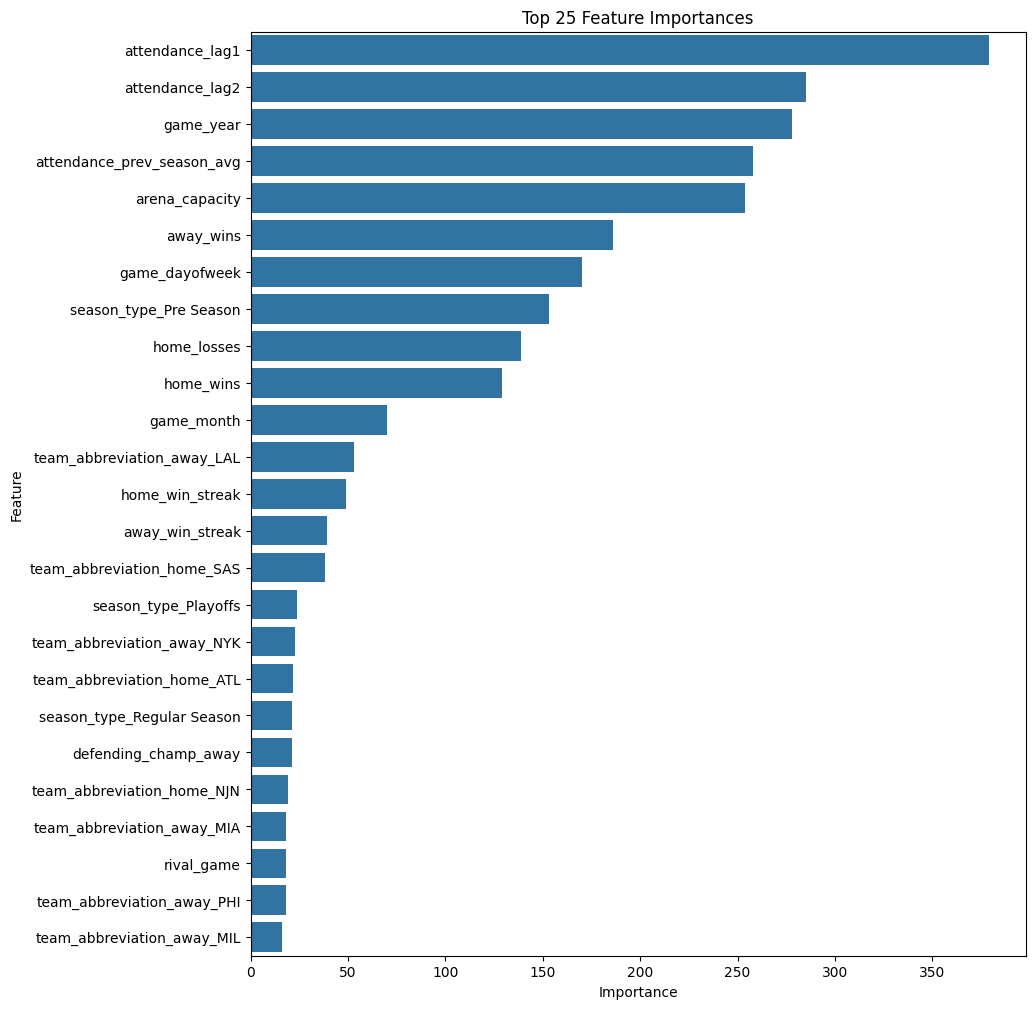

In [46]:
importances = lgbm_model.feature_importances_
feat_names = X.columns

# Plot
feat_imp_df = pd.DataFrame({'Feature': feat_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values('Importance', ascending=False).head(25)

plt.figure(figsize=(10, 12))
sns.barplot(data=feat_imp_df, x='Importance', y='Feature')
plt.title('Top 25 Feature Importances')
plt.show()

#### SHAP Anaylsis

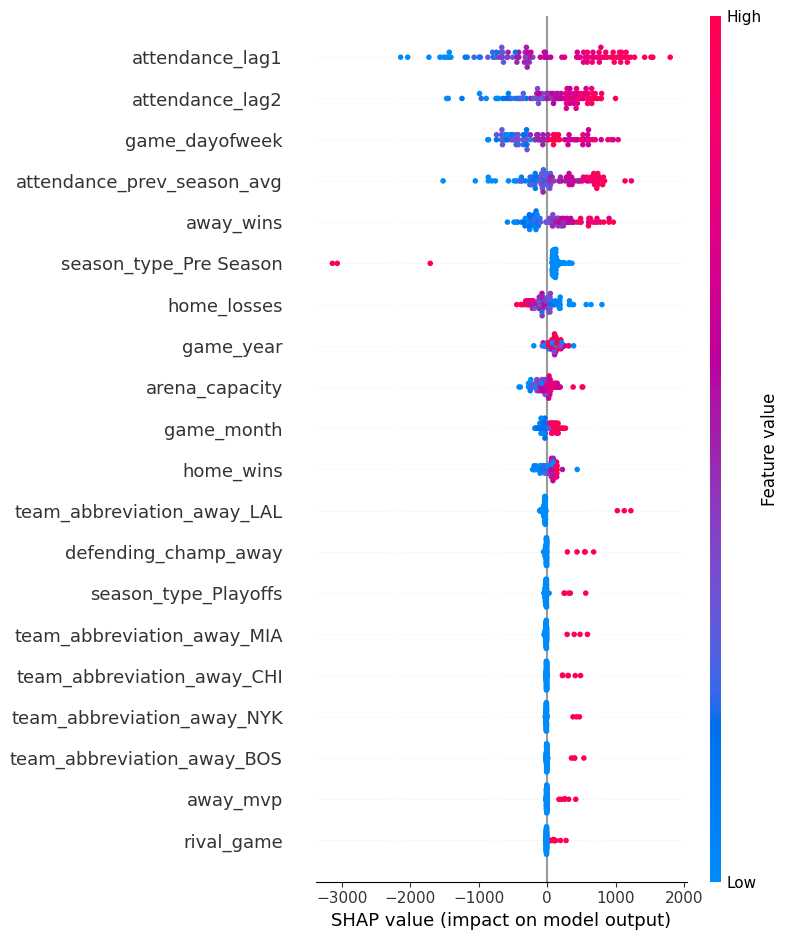

In [47]:
import shap
import numpy as np

# Sicherstellen, dass TreeExplainer verwendet wird (schneller bei Tree-basierten Modellen)
explainer = shap.TreeExplainer(lgbm_model)

# Nur zufällige Stichprobe von Testdaten nutzen
sample_size = 100
sample_idx = np.random.choice(X_test.index, size=min(sample_size, len(X_test)), replace=False)
X_test_sample = X_test.loc[sample_idx]

# SHAP-Werte berechnen (nur für die Stichprobe)
shap_values = explainer.shap_values(X_test_sample)

# Übersicht der globalen Feature-Wichtigkeit (Summary Plot)
shap.summary_plot(shap_values, X_test_sample, max_display=20)
